<a href="https://colab.research.google.com/github/pacomm5/curso-series-temporales/blob/master/5.%20Modelos%20AR%20autorregresivos/Python/Tarea_Retornos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the relevant packages


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
import seaborn as sns
sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importing the Data and Pre-processing 

In [2]:
raw_csv_data = pd.read_csv("https://raw.githubusercontent.com/MaddoSaru/curso-series-temporales/master/3.%20Caracter%C3%ADsticas%20fundamentales/Python/Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value']=df_comp.ftse #ftse

In [4]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [6]:
# vamos a a hacer adfuller para ver si es estacionario
sts.adfuller(df.market_value)
# no es estacionario. 
# por lo tanto deducimos que podemos tener problemas con los modelos autoregresivos

(-1.9041551418836864,
 0.33010893277028336,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '10%': -2.5670769326348926,
  '5%': -2.8621166146845334},
 54854.15304507557)

#USANDO RETORNOS.

In [7]:
# los retornos son un porcentaje de cambio entre dos periodos consecutivos. 
df["returns"] = df.market_value.pct_change(1).mul(100) # pct_change es el porcentaje de cambio. lo guardamos como returns. le ponemos uno que es valor anterior. 
df = df.iloc[1:] # nos elimina la primera fila

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
df # vemos que al observar los datos con returns los datos si son estacionarios. 

,market_value,returns
date,,
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166
1994-01-14,3400.56,1.206842
...,...,...
2013-04-01,6411.74,0.000000
2013-04-02,6490.66,1.230867
2013-04-03,6420.28,-1.084327


In [11]:
# aqui lo estamos haciendo sobre returns
sts.adfuller(df.returns) # eso quiere decir que es estacionaria. el p valor es tiene e-24 es decir 0,0000000007

(-12.770265719497184,
 7.79805833604023e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '10%': -2.5670785949998973,
  '5%': -2.8621197374408225},
 15696.7672456975)

## The ACF

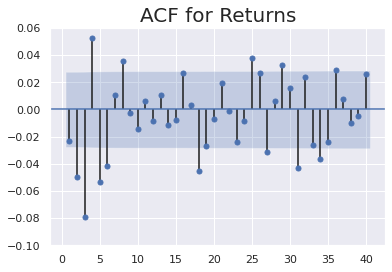

In [14]:
sgt.plot_acf(df.returns, zero = False, lags = 40)
plt.title("ACF for Returns", size = 20)
plt.ylim(-.1, 0.06) # con esto estamos acotando el grafico.
plt.show()
# 

## The PACF

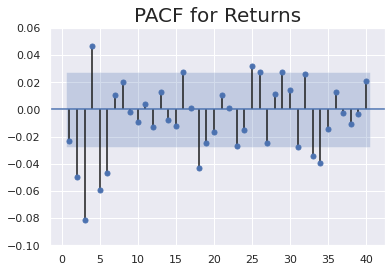

In [15]:
sgt.plot_pacf(df.returns, lags = 40, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF for Returns", size = 20)
plt.ylim(-.1, 0.06)
plt.show()
# correlación parcial. 
# es mejor esta, la parcial porque muestra la mayor´ía de los puntos dentro de los limites, y la otra la de arriba auque es muy similar, se diferente de lo que necesitamos de ella. 
# tomariamos 6 retrasos porque en el gráfico se ve que son los que están fuera. 

## The AR(1) Model

Ahora vamos a hacer el analisis del model AR(1) y de sus residuos.
entiendo que el del market value lo tenemos arriba asi que lo vamos a hacer sobre los residuos. 

In [17]:
# este es el del modelo 1
model_ar = ARMA(df.market_value, order=(1,0)) # 1 es el número de retrasos. y el 0, es que no estamos tendiendo en cuenta los valores residuales. 
# lo guardamos en la variable model_ar
# vamos a incluir solo el primer retraso

In [18]:
model_ar_residuos = ARMA(df.returns, order=(1,0))

In [19]:
results_ar = model_ar.fit() # aqui lo guardamos ajustado

In [20]:
results_ar_residuos = model_ar_residuos.fit()

In [ ]:
results_ar.summary() # aqui tenemos un resumen de todos los valores. 
# ar.L1 significa el retraso 1
# 50567 el valor de la constante. y 0,9985 es el valor del coeficiente. asociado al primer retraso.
# std es la desviación estandar. 
#z es el valor del estadistico de prueba. 
# el p>z es significativo porque es menor que 0,05

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(1, 0)   Log Likelihood              -27622.599
Method:                       css-mle   S.D. of innovations             59.258
Date:                Sun, 13 Feb 2022   AIC                          55251.198
Time:                        21:30:40   BIC                          55270.762
Sample:                    01-07-1994   HQIC                         55258.054
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5067.4707    486.503     10.416      0.000    4113.942    6021.000
ar.L1.market_value     0.9985      0.001   1298.545      0.000       0.997       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
-----------------------------------------------------------------------------
"""

In [21]:
results_ar_residuos.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 0)   Log Likelihood               -7929.749
Method:                       css-mle   S.D. of innovations              1.174
Date:                Fri, 18 Feb 2022   AIC                          15865.497
Time:                        11:25:42   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.159      0.247      -0.013       0.051
ar.L1.returns    -0.0230      0.014     -1.631      0.103      -0.051       0.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.4386           +0.0000j           43.4386            0.5000
-----------------------------------------------------------------------------
"""

In [27]:
# me voy directamento al 7 y vemos que no nos vale por que el último valor su p valor no es correcto
model_ar_residuos7 = ARMA(df.returns, order=(7,0))
results_ar_residuos7 = model_ar_residuos7.fit()
results_ar_residuos7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(7, 0)   Log Likelihood               -7886.647
Method:                       css-mle   S.D. of innovations              1.164
Date:                Fri, 18 Feb 2022   AIC                          15791.294
Time:                        11:38:51   BIC                          15849.985
Sample:                    01-10-1994   HQIC                         15811.860
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.399      0.162      -0.008       0.045
ar.L1.returns    -0.0240      0.014     -1.702      0.089      -0.052       0.004
ar.L2.returns    -0.0517      0.014     -3.663      0.000      -0.079      -0.024
ar.L3.returns    -0.0874      0.014     -6.202      0.000      -0.115      -0.060
ar.L4.returns     0.0433      0.014      3.064      0.002       0.016       0.071
ar.L5.returns    -0.0601      0.014     -4.263      0.000      -0.088      -0.032
ar.L6.returns    -0.0463      0.014     -3.282      0.001      -0.074      -0.019
ar.L7.returns     0.0109      0.014      0.772      0.440      -0.017       0.039
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6490           -0.5384j            1.7347           -0.4498
AR.2           -1.6490           +0.5384j            1.7347            0.4498
AR.3           -0.1189           -1.4954j            1.5001           -0.2626
AR.4           -0.1189           +1.4954j            1.5001            0.2626
AR.5            1.2790           -0.9786j            1.6105           -0.1039
AR.6            1.2790           +0.9786j            1.6105            0.1039
AR.7            5.2270           -0.0000j            5.2270           -0.0000
-----------------------------------------------------------------------------
"""

In [26]:
# este sería el bueno. 
model_ar_residuos6 = ARMA(df.returns, order=(6,0))
results_ar_residuos6 = model_ar_residuos6.fit()
results_ar_residuos6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(6, 0)   Log Likelihood               -7886.945
Method:                       css-mle   S.D. of innovations              1.164
Date:                Fri, 18 Feb 2022   AIC                          15789.890
Time:                        11:38:03   BIC                          15842.059
Sample:                    01-10-1994   HQIC                         15808.170
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.414      0.157      -0.007       0.045
ar.L1.returns    -0.0245      0.014     -1.740      0.082      -0.052       0.003
ar.L2.returns    -0.0523      0.014     -3.716      0.000      -0.080      -0.025
ar.L3.returns    -0.0870      0.014     -6.174      0.000      -0.115      -0.059
ar.L4.returns     0.0424      0.014      3.009      0.003       0.015       0.070
ar.L5.returns    -0.0607      0.014     -4.309      0.000      -0.088      -0.033
ar.L6.returns    -0.0466      0.014     -3.302      0.001      -0.074      -0.019
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2869           -0.9022j            1.5716           -0.0973
AR.2            1.2869           +0.9022j            1.5716            0.0973
AR.3           -0.0727           -1.5282j            1.5299           -0.2576
AR.4           -0.0727           +1.5282j            1.5299            0.2576
AR.5           -1.8659           -0.4836j            1.9275           -0.4596
AR.6           -1.8659           +0.4836j            1.9275            0.4596
-----------------------------------------------------------------------------
"""

## Higher-Lag AR Models

In [ ]:
model_ar_2 = ARMA(df.market_value, order=(2,0)) # este es de orden 2 es decir con dos periodos atrás. 
results_ar_2 = model_ar_2.fit()
results_ar_2.summary()
# aqui el valor de pvalor para el segundo coeficiente no es significativo. es decir que el precio de hace dos días no afecta a los precios de hoy. 
# creo que los podemos descartar. 


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(2, 0)   Log Likelihood              -27621.866
Method:                       css-mle   S.D. of innovations             59.249
Date:                Sun, 13 Feb 2022   AIC                          55251.732
Time:                        21:35:49   BIC                          55277.817
Sample:                    01-07-1994   HQIC                         55260.872
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5028.8087    495.980     10.139      0.000    4056.706    6000.911
ar.L1.market_value     0.9814      0.014     69.595      0.000       0.954       1.009
ar.L2.market_value     0.0171      0.014      1.211      0.226      -0.011       0.045
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
AR.2          -58.4562           +0.0000j           58.4562            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
model_ar_3 = ARMA(df.market_value, order=(3,0))
results_ar_3 = model_ar_3.fit()
results_ar_3.summary()
# vemos que el último es significativo.

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(3, 0)   Log Likelihood              -27615.871
Method:                       css-mle   S.D. of innovations             59.178
Date:                Sun, 13 Feb 2022   AIC                          55241.742
Time:                        21:34:10   BIC                          55274.349
Sample:                    01-07-1994   HQIC                         55253.168
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6413    520.345      9.781      0.000    4069.784    6109.499
ar.L1.market_value     0.9806      0.014     69.619      0.000       0.953       1.008
ar.L2.market_value    -0.0309      0.020     -1.563      0.118      -0.070       0.008
ar.L3.market_value     0.0489      0.014      3.466      0.001       0.021       0.077
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0013           -0.0000j            1.0013           -0.0000
AR.2           -0.1850           -4.5161j            4.5199           -0.2565
AR.3           -0.1850           +4.5161j            4.5199            0.2565
-----------------------------------------------------------------------------
"""

In [ ]:
model_ar_4 = ARMA(df.market_value, order=[4,0])
results_ar_4 = model_ar_4.fit()
results_ar_4.summary()
# vemos que el útlimo es significativo.
# vemos que va subiendo log likeihood o grado de verosimilitud y bajando AIC Y BIC. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(4, 0)   Log Likelihood              -27602.569
Method:                       css-mle   S.D. of innovations             59.022
Date:                Sun, 13 Feb 2022   AIC                          55217.138
Time:                        21:34:26   BIC                          55256.266
Sample:                    01-07-1994   HQIC                         55230.849
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5107.1947    562.142      9.085      0.000    4005.417    6208.972
ar.L1.market_value     0.9770      0.014     69.492      0.000       0.949       1.005
ar.L2.market_value    -0.0286      0.020     -1.455      0.146      -0.067       0.010
ar.L3.market_value    -0.0224      0.020     -1.135      0.256      -0.061       0.016
ar.L4.market_value     0.0728      0.014      5.166      0.000       0.045       0.100
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0011           -0.0000j            1.0011           -0.0000
AR.2            0.9549           -2.0884j            2.2964           -0.1817
AR.3            0.9549           +2.0884j            2.2964            0.1817
AR.4           -2.6036           -0.0000j            2.6036           -0.5000
-----------------------------------------------------------------------------
"""

## LLR Test

In [ ]:
def LLR_test(mod_1, mod_2, DF=1): # DF son grados de libertad. 
    L1 = mod_1.llf # valor de verosimilitud. 
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p
# ESTO ES UNA FUNCIÓN PARA QUE NOS DEVUELVA EL P VALOR. 

## Comparing Higher-Lag AR Models

In [ ]:
LLR_test(results_ar_2, results_ar_3) # esto quiere decir que son similares es decir que son diferentes, por lo tanto nos quedaríamos con el más compejo e3 3
# menor que 0,05

0.001

In [ ]:
LLR_test(results_ar_3, results_ar_4) # aquí con el 4

0.0

In [ ]:
model_ar_4 = ARMA(df.market_value, order=[4,0])
results_ar_4 = model_ar_4.fit()
print(results_ar_4.summary()) 
print ("LLR test: " + str(LLR_test(results_ar_3, results_ar_4)))

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(4, 0)   Log Likelihood              -27602.569
Method:                       css-mle   S.D. of innovations             59.022
Date:                Sun, 13 Feb 2022   AIC                          55217.138
Time:                        21:54:31   BIC                          55256.266
Sample:                    01-07-1994   HQIC                         55230.849
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5107.1947    562.142      9.085      0.000    4005.417    6208.972
ar.L1.market_value     0.9770      0.014     69.492      0.000       0.949       1.005
ar.L2.market_value  

In [ ]:
model_ar_5 = ARMA(df.market_value, order=(5,0))
results_ar_5 = model_ar_5.fit()
print(results_ar_5.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_4, results_ar_5)))
# aui hacemos dos cosas, lo de arriba y vemos el p valor. 
# vemos que el pvalor del újltimo el significativo poruqe es menor que 0,05

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(5, 0)   Log Likelihood              -27600.348
Method:                       css-mle   S.D. of innovations             58.996
Date:                Sun, 13 Feb 2022   AIC                          55214.697
Time:                        21:59:12   BIC                          55260.346
Sample:                    01-07-1994   HQIC                         55230.693
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6414    543.596      9.363      0.000    4024.213    6155.070
ar.L1.market_value     0.9791      0.014     69.481      0.000       0.952       1.007
ar.L2.market_value  

In [ ]:
model_ar_6 = ARMA(df.market_value, order=(6,0))
results_ar_6 = model_ar_6.fit()
print(results_ar_6.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_5, results_ar_6)))
# vemos que el último es significativo

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 0)   Log Likelihood              -27596.474
Method:                       css-mle   S.D. of innovations             58.950
Date:                Sun, 13 Feb 2022   AIC                          55208.947
Time:                        22:01:33   BIC                          55261.118
Sample:                    01-07-1994   HQIC                         55227.229
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6413    565.172      9.005      0.000    3981.925    6197.357
ar.L1.market_value     0.9803      0.014     69.604      0.000       0.953       1.008
ar.L2.market_value  

In [ ]:
model_ar_7 = ARMA(df.market_value, order=(7,0))
results_ar_7 = model_ar_7.fit()
print(results_ar_7.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_6, results_ar_7)))

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(7, 0)   Log Likelihood              -27591.900
Method:                       css-mle   S.D. of innovations             58.896
Date:                Sun, 13 Feb 2022   AIC                          55201.799
Time:                        22:01:37   BIC                          55260.492
Sample:                    01-07-1994   HQIC                         55222.366
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6411    589.587      8.633      0.000    3934.072    6245.210
ar.L1.market_value     0.9786      0.014     69.518      0.000       0.951       1.006
ar.L2.market_value  

In [ ]:
model_ar_8 = ARMA(df.market_value, order=(8,0))
results_ar_8 = model_ar_8.fit()
print(results_ar_8.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_7, results_ar_8)))
# el 8 no es significativo y el pvalor del modelo tampoco lo es. 
# por lo tanto nos quedamos con el 7 aunque tenga valores no significativos en el 2,3 y 6

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(8, 0)   Log Likelihood              -27591.739
Method:                       css-mle   S.D. of innovations             58.894
Date:                Sun, 13 Feb 2022   AIC                          55203.478
Time:                        22:01:46   BIC                          55268.692
Sample:                    01-07-1994   HQIC                         55226.329
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6415    584.948      8.701      0.000    3943.165    6236.118
ar.L1.market_value     0.9790      0.014     69.476      0.000       0.951       1.007
ar.L2.market_value  

In [ ]:
print("LLR test: " + str(LLR_test(results_ar, results_ar_7, DF = 6)))
# el resultado es significativo. 
# comio tenemos p no significativos tenemos que hacer más cosas. 

LLR test: 0.0


## Analysing the Residuals

In [ ]:
df['res_price'] = results_ar_7.resid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
sts.adfuller(df.res_price)
# aqui vemos que el p valor es 0, por lo tanto es estacionaria. 

(-76.07469620991299,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '10%': -2.5670765656497516,
  '5%': -2.8621159253018247},
 54842.41512231188)

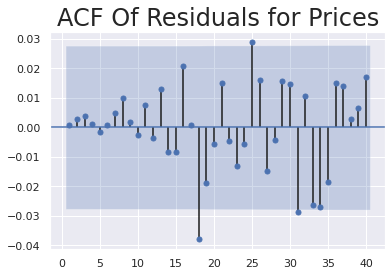

In [ ]:
sgt.plot_acf(df.res_price, zero = False, lags = 40)
plt.title("ACF Of Residuals for Prices",size=24)
plt.show()
# algunos valores salen 

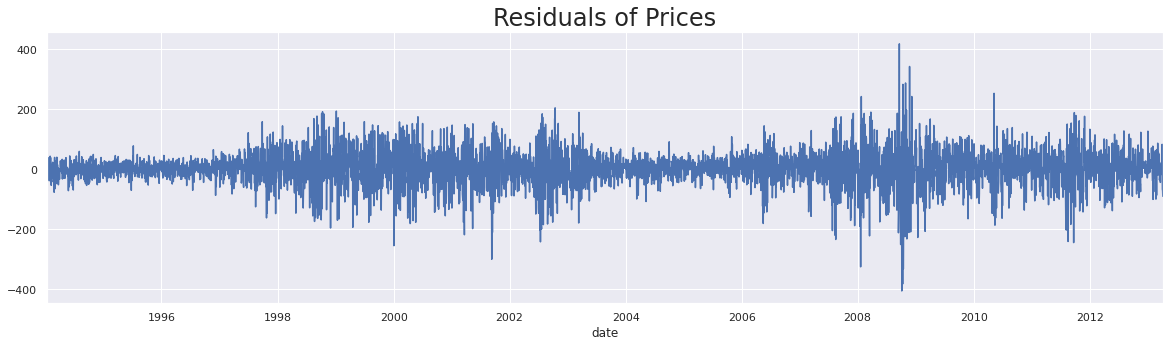

In [ ]:
df.res_price[1:].plot(figsize=(20,5))
plt.title("Residuals of Prices",size=24)
plt.show()